In [1]:
%load_ext autoreload
%autoreload 2
import os

In [2]:
#!pip3 install pytorch
!pip3 install multiprocess
import torch
torch.cuda.empty_cache()

#!pip3 install sentence-transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator, CEBinaryClassificationEvaluator
from torch.utils.data import DataLoader
import math
import plotly
import plotly.graph_objs as go
import plotly.io as pio
plotly.offline.init_notebook_mode(connected=True)
import multiprocess as multiprocessing
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from sentence_transformers import InputExample
import logging
!pip3 install transformers
import json
import pickle
import numpy as np
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from writeprints import get_writeprints_transformer, prepare_entry
from utills import batch
from pytorch_models import NeuralNet
import torch
import torch.nn as nn
from torch.utils import data
import copy
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from transformers import BertTokenizerFast
import datetime
import time
from pan20_verif_evaluator import evaluate_all
import nltk
nltk.download('punkt')

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to
[nltk_data]     /storagenfs/g.pisciotta1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Constants
DATA_DIR = 'data/small/'
TEMP_DATA_DIR = 'temp_data/pan20_computed/'

Load ground truth
====

In [4]:
# Load gound truth
ground_truth = {}
partition = {}

#tot = 52601/3
limited = False
tot = 20000
n_of_pos_we_want = tot/2
n_of_neg_we_want = tot/2
# quindi in totale 1_000

positive_samples = 0
negative_samples = 0
total = 0

# Qui apriamo il dataset e estraiamo un totale di 10k esempi del task
with open(DATA_DIR + '/pan20-authorship-verification-training-small-truth.jsonl', 'r') as f:
    
    for counter, l in tqdm(enumerate(f)):
        total += 1
        
        d = json.loads(l)

        if d['same']:# and positive_samples < n_of_pos_we_want : # se la label è true e dobbiamo ancora aggiungerne
            ground_truth[d['id']] = d['same']
            positive_samples += 1
        elif not d['same']:# and negative_samples < n_of_neg_we_want:
            ground_truth[d['id']] = d['same']
            negative_samples += 1
            
        # Una volta che abbiamo raggiunto il numero di dati che vogliamo, è fatta, usciamo
        #if limited and (positive_samples == n_of_pos_we_want and negative_samples == n_of_neg_we_want):
        #    break
            
print(total, positive_samples, negative_samples)


52601 27834 24767


Partially extract features
===

In [25]:
samples = multiprocessing.Manager().Queue()

from sklearn.model_selection import train_test_split                 
def process_pair(l):
    d = json.loads(l)
    if d['id'] in ground_truth:
        #e1 = prepare_entry(d['pair'][0])
        #e2 = prepare_entry(d['pair'][1])
        e1 = d['pair'][0]
        e2 = d['pair'][1]
        samples.put({'id': d['id'], 'doc1': e1, 'doc2': e2})
        return {'id': d['id'], 'doc1':e1, 'doc2':e2}    


start_time = datetime.datetime.now()
print("Started handling of each pair")
with open(DATA_DIR + 'pan20-authorship-verification-training-small.jsonl', 'r') as f:
    with multiprocessing.Pool() as pool:
        samples = pool.map(process_pair, (l for l in f))
print("Ended handling of each pair")        

end_time = datetime.datetime.now()
print("Time spent: ", (end_time-start_time).total_seconds())




Started handling of each pair
Ended handling of each pair
Time spent:  36.083156


Split dataset
=====

In [26]:
labels = []

# Il processo in parallelo restituisce comunque eventualmente dei None se 
# il sample non appartiene alla lista di quelli che abbiamo selezionato,
# quindi nel caso rimuoviamo i None così
samples = [i for i in samples if i is not None]

for s in samples:
    # Qui non dovrebbe arrivare
    if s is None:
        print("None")
        break
        
    # Questo dovrebbe essere il caso normale
    else:
        s['label'] = int(ground_truth[s['id']])

import pandas as pd
df = pd.DataFrame(samples)
df = df.set_index('id')

X_design, X_test, y_design, y_test = train_test_split(df, df['label'], stratify=df['label'], random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_design, y_design, stratify=y_design, random_state=42)

# Per salvare
X_test.to_pickle(TEMP_DATA_DIR+"x_test.pkl")
X_valid.to_pickle(TEMP_DATA_DIR+"x_valid.pkl")
X_train.to_pickle(TEMP_DATA_DIR+"x_train.pkl")
df.to_pickle(TEMP_DATA_DIR+"df.pkl")
df.to_pickle('permiriana.pkl')

In [29]:
df

,doc1,doc2,label
id,,,
6cced668-6e51-5212-873c-717f2bc91ce6,"I shift a bit, warily letting my eyes dart fro...","""All will become one with Russia,"" he said, al...",1
3c6c188a-db28-59aa-8c09-3d0f799ff579,"I shift a bit, warily letting my eyes dart fro...","Suddenly, a piece of ice falls into the pit of...",1
b0cfa94f-c9ec-5aa5-8331-a5a249b664cf,A single tear escaped me as I left. I did have...,"got the Yang yoyo."" Kimiko pulled the other ha...",1
e6e86e73-9a7b-58f2-a652-a17b4a1bcabf,"""Ja."" Ludwig kept his gaze upon her, solidly. ...",SilverGray lll...YellowRagged llll...GrayMilli...,1
4fe541af-912e-5a86-81a5-94c6d3891509,"And he did. Slowly, hesitantly...but coming fr...","""Let""s go,"" Raimondo said and then started in ...",1
...,...,...,...
3926a1bd-6d33-5513-a694-12d7590443d4,Enjoy! And time stands still beneath the air o...,"""That a challenge, dick?"" Austin smirks back a...",0
17227d87-a3cb-5aca-b5fd-bb642e88b030,"""I forgive you,"" she blurted out looking strai...","This is a KNB fanfic. KNB doesn""t belong to me...",0
0332dcaa-7230-508b-badb-820f9d8eebaa,"""What? Why? What""s happening? Where are we goi...","At the moment, Chris"" position on the swing se...",0


In [5]:
import pandas as pd
df = pd.read_pickle('permiriana.pkl')
df1 = df[['doc1']]
df1['doc1'] = df1['doc1'].str.lower()
df1 = df1.drop_duplicates()


<ipython-input-5-cb0fccdfb0a6>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:

doc1 = df1['doc1'].str.cat(sep='. ')


In [7]:
from nltk.tokenize import word_tokenize
wordlists = word_tokenize(doc1)

In [8]:

from nltk.probability import FreqDist
fdist = FreqDist(wordlists)
fdist

fdist.freq('she')


0.010869295430944228

[nltk_data] Downloading package stopwords to
[nltk_data]     /storagenfs/g.pisciotta1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


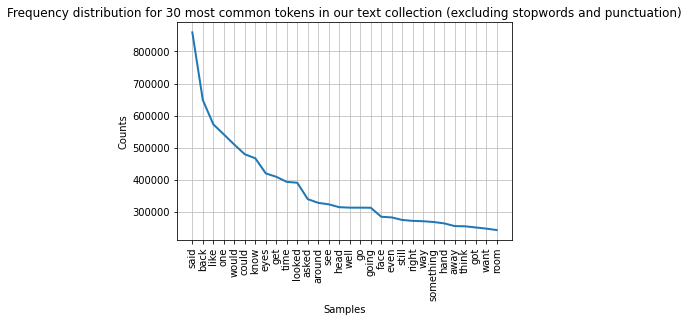

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)'}, xlabel='Samples', ylabel='Counts'>

In [21]:
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
remove_these = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) + ["...", "``","''"])
filtered_text = [w for w in wordlists if not w in remove_these]
fdist_filtered = FreqDist(filtered_text)
fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')



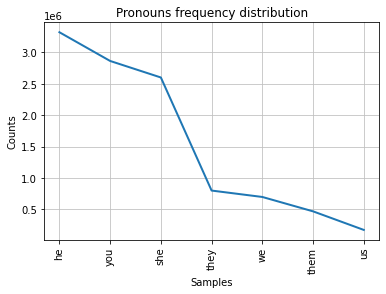

<AxesSubplot:title={'center':'Pronouns frequency distribution'}, xlabel='Samples', ylabel='Counts'>

In [40]:
filtered_text_with_pronouns = [w for w in wordlists if w in ['we', 'us', 'you', 'they', 'she', 'he', 'them']]
fdist_filtered = FreqDist(filtered_text_with_pronouns)
fdist_filtered.plot(30,title='Pronouns frequency distribution')

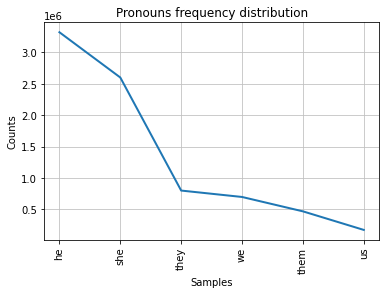

<AxesSubplot:title={'center':'Pronouns frequency distribution'}, xlabel='Samples', ylabel='Counts'>

In [41]:
filtered_text_with_pronouns = [w for w in wordlists if w in ['we', 'us', 'they', 'she', 'he', 'them']]
fdist_filtered = FreqDist(filtered_text_with_pronouns)
fdist_filtered.plot(30,title='Pronouns frequency distribution')

In [82]:
i=0
t1s = []
t2s = []
grounds = []
fandoms = []
previous_ground = -1

with open(DATA_DIR + 'pan20-authorship-verification-training-small.jsonl', 'r') as f:
    for l in f:
        d = json.loads(l)

        ground = ground_truth[d['id']]
         
        if previous_ground == -1 or ground != previous_ground:
            previous_ground = ground
            t1 = " ".join(d['pair'][0].split(" ")[:50])+" [...]"
            t2 = " ".join(d['pair'][1].split(" ")[:50])+" [...]"
            t1s.append(t1)
            t2s.append(t2)
            grounds.append(ground)
            fandoms.append(", ".join(d['fandoms']))
            if i > 5:
                break
            i+=1

minidf = pd.DataFrame({'doc 1':t1s, 'doc 2':t2s, 'same author': grounds, 'fandom': fandoms})
display(minidf)
print(minidf.to_latex())

with open(DATA_DIR + '/pan20-authorship-verification-training-small-truth.jsonl', 'r') as f:
    
    for l in f:
        d = json.loads(l)
        print(d.keys())
        if len(set(d['authors']))>2 :
               print(d['authors'])
        break
        


,doc 1,doc 2,same author,fandom
0,"I shift a bit, warily letting my eyes dart fro...","""All will become one with Russia,"" he said, al...",True,"Guardians of Ga'Hoole, Hetalia - Axis Powers"
1,"""Told you."" Jay walked over to the group of si...","smiled then whispered, ""Can never say no to Ma...",False,"Hocus Pocus, Boondock Saints"


\begin{tabular}{lllll}
\toprule
{} &                                              doc 1 &                                              doc 2 &  same author &                                        fandom \\
\midrule
0 &  I shift a bit, warily letting my eyes dart fro... &  "All will become one with Russia," he said, al... &         True &  Guardians of Ga'Hoole, Hetalia - Axis Powers \\
1 &  "Told you." Jay walked over to the group of si... &  smiled then whispered, "Can never say no to Ma... &        False &                  Hocus Pocus, Boondock Saints \\
\bottomrule
\end{tabular}

dict_keys(['id', 'same', 'authors'])


In [22]:
with open(DATA_DIR + 'pan20-authorship-verification-training-small.jsonl', 'r') as f:
    for l in f:
        d = json.loads(l)
        print(d.keys())
        print(d)
        break

dict_keys(['id', 'fandoms', 'pair'])
{'id': '6cced668-6e51-5212-873c-717f2bc91ce6', 'fandoms': ["Guardians of Ga'Hoole", 'Hetalia - Axis Powers'], 'pair': ['I shift a bit, warily letting my eyes dart from one owl to the other -- but my eyes are trained on the Barn Owl the most. Like Hoole...so like Hoole... He turns a bit, and our eyes meet directly. I can"t describe it...in this next moment, I don"t look away, how awkward it seems. I stare into his eyes. They"re like Hoole"s... They are Barn Owl eyes, but Hoole"s eyes. They"re his eyes...Hoole"s eyes... They hold that light of valor, justice, that one glow that I always made me feel my gizzard twitch in the bottom of my heart. Hoole... He never wanted me, did he? He loved me, but only who I was pretending to be. He never loved me, only Emerilla...lucky owl. I just wanted to belong -- because I was nothing -- and he gave me that. He was so fair, so kind...he gave me something even Kreeth could not. Mum and Da -- Ygryk and Pleek -- were

In [ ]:
from collections import Counter
dictionary=Counter(filtered_text)
import matplotlib.pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(dictionary)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Fit the feature sklearn transformer 
======

In [9]:
start = datetime.datetime.now()

docs = list(X_train['doc1']) + list(X_train['doc2'])
transformer = get_writeprints_transformer()
X = transformer.fit_transform(docs[:len(docs)//4]) # Usiamo 1/4 dei docs per fittare, valori più alti fanno esplodere
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)

with open(TEMP_DATA_DIR + 'transformers.p', 'wb') as f:
    pickle.dump((transformer, scaler), f)

end = datetime.datetime.now()
print("Time: ", (end-start).total_seconds())

/usr/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Time:  2698.403188


Vectorize the training data
======

In [10]:
start = datetime.datetime.now()

x1 = scaler.transform(transformer.transform(X_train['doc1']))
x2 = scaler.transform(transformer.transform(X_train['doc2']))

X_train_features = pd.DataFrame(np.abs(x1-x2).todense())

end = datetime.datetime.now()
print("Time: ", (end-start).total_seconds())

KeyboardInterrupt: 

Vectorize the test data
=====

In [ ]:
start = datetime.datetime.now()

x1 = scaler.transform(transformer.transform(X_test['doc1']))
x2 = scaler.transform(transformer.transform(X_test['doc2']))

X_test_features = pd.DataFrame(np.abs(x1-x2).todense())

end = datetime.datetime.now()
print("Time: ", (end-start).total_seconds())

Vectorize the Val data
====

In [ ]:
start = datetime.datetime.now()
        
x1 = scaler.transform(transformer.transform(X_valid['doc1']))
x2 = scaler.transform(transformer.transform(X_valid['doc2']))
X_valid_features = pd.DataFrame(np.abs(x1-x2).todense())

end = datetime.datetime.now()
print("Time: ", (end-start).total_seconds())

Save to (or read from) pickle files
====

In [ ]:
import pickle, pandas as pd
df = pd.read_pickle('permiriana.pkl')

"""# Per salvare
X_test_features.to_pickle(TEMP_DATA_DIR+"x_test_features.pkl")
X_valid_features.to_pickle(TEMP_DATA_DIR+"x_valid_features.pkl")
X_train_features.to_pickle(TEMP_DATA_DIR+"x_train_features.pkl")

X_test.to_pickle(TEMP_DATA_DIR+"x_test.pkl")
X_valid.to_pickle(TEMP_DATA_DIR+"x_valid.pkl")
X_train.to_pickle(TEMP_DATA_DIR+"x_train.pkl")

df.to_pickle(TEMP_DATA_DIR+"df.pkl")"""


"""
# Per leggere quelli già salvati
X_test_features = pd.read_pickle(TEMP_DATA_DIR+"/x_test_features.pkl")
X_valid_features = pd.read_pickle(TEMP_DATA_DIR+"/x_valid_features.pkl")
X_train_features = pd.read_pickle(TEMP_DATA_DIR+"/x_train_features.pkl")

X_test = pd.read_pickle(TEMP_DATA_DIR+"/x_test.pkl")
X_valid = pd.read_pickle(TEMP_DATA_DIR+"/x_valid.pkl")
X_train = pd.read_pickle(TEMP_DATA_DIR+"/x_train.pkl")

df = pd.read_pickle(TEMP_DATA_DIR+"/df.pkl")
y_train = X_train[['label']]
y_valid = X_test[['label']]
y_test = X_test[['label']]

with open(TEMP_DATA_DIR + 'transformers.p', 'rb') as f:
    transformer, scaler = pickle.load(f)
    
with open(TEMP_DATA_DIR + 'ordering_metadata.p', 'rb') as f:
    train_sz, test_sz, val_sz, train_idxs = pickle.load(f)
    
with open(TEMP_DATA_DIR + 'ordering_metadata.p', 'rb') as f:
    train_idxs = pickle.load(f)


Train Classifier: Logistic Regression
===

In [ ]:
clf = LogisticRegression(random_state=42, verbose=1).fit(X_train_features, y_train)
y_pred = clf.predict(X_test_features)
y_test_new = []
for i, row in y_test.iterrows():
    y_test_new.append(row.values[0])
y_test_new = np.array(y_test_new)
y_test = y_test_new
print(evaluate_all(y_test, y_pred))

Embedding Model
===


## Load the dataset made of pairs of documents

In [9]:
train_samples = []
valid_samples = []
test_samples = []

for i, row_dict in X_train.iterrows():
    train_samples.append(InputExample(texts=[row_dict['doc1']['preprocessed'], row_dict['doc2']['preprocessed']], label=int(ground_truth[i])))
    #train_samples.append(InputExample(texts=[row_dict['doc2']['preprocessed'], row_dict['doc1']['preprocessed']], label=int(ground_truth[i])))

for i, row_dict in X_valid.iterrows():
    valid_samples.append(InputExample(texts=[row_dict['doc1']['preprocessed'], row_dict['doc2']['preprocessed']], label=int(ground_truth[i])))

for i, row_dict in X_test.iterrows():
    test_samples.append(InputExample(texts=[row_dict['doc1']['preprocessed'], row_dict['doc2']['preprocessed']], label=int(ground_truth[i])))

## Test pretrained Cross-Encoder model

In [ ]:
"""model_save_path = 'output/training_stsbenchmark-'+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = 'cross-encoder/stsb-TinyBERT-L-4'
model = CrossEncoder(model_name, num_labels=1,device='cuda')

y_pred = []

for row_dict in X_test.to_dict(orient="records"):
    y_pred.append(
        model.predict(
            [row_dict['doc1'], row_dict['doc2']]
        )
    )

print(evaluate_all(y_test, y_pred))"""

## Fine tune pretrained Cross-Encoder model on our dataset

In [11]:
# Load previously trained model
model_name = 'output/training_stsbenchmark-2021-06-30_13-47-37'

model = CrossEncoder(model_name, num_labels=1, device='cuda')


y_pred = []
for row_dict in X_test.to_dict(orient="records"):
    y_pred.append(
        model.predict(
            [row_dict['doc1']['preprocessed'], row_dict['doc2']['preprocessed']]
        )
    )
print(evaluate_all(y_test, y_pred))


{'auc': 0.76, 'c@1': 0.68, 'f_05_u': 0.712, 'F1': 0.664, 'overall': 0.704}


NameError: name 'y_true' is not defined

In [14]:
new_y_pred = []
for y in y_pred:
    new_y_pred.append(np.round(np.clip(y, 0, 1)))

In [17]:
from sklearn.metrics import classification_report
new_y_pred = []
for y in y_pred:
    new_y_pred.append(np.round(np.clip(y, 0, 1)))
print(classification_report(y_test, new_y_pred))

              precision    recall  f1-score   support

           0       0.63      0.77      0.69      6192
           1       0.75      0.60      0.66      6959

    accuracy                           0.68     13151
   macro avg       0.69      0.69      0.68     13151
weighted avg       0.69      0.68      0.68     13151



In [ ]:
# Load previously trained model
#model_name = 'output/training_stsbenchmark-2021-06-29_16-27-18'

# Fine-tune model

train_batch_size = 32
num_epochs = 2
model_save_path = 'output/training_stsbenchmark-'+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

# Load preloaded model
model_name = 'cross-encoder/ms-marco-TinyBERT-L-2'
model = CrossEncoder(model_name, num_labels=1, device='cuda')

# We add an evaluator, which evaluates the performance during training
evaluator = CEBinaryClassificationEvaluator.from_input_examples(valid_samples, name='sts-valid')

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up

model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

##### Load model and eval on test set
#model = CrossEncoder(model_save_path)
evaluator = CEBinaryClassificationEvaluator.from_input_examples(test_samples, name='sts-test')

print("Evaluator: ", evaluator(model))


y_pred = []
for row_dict in X_test.to_dict(orient="records"):
    y_pred.append(
        model.predict(
            [row_dict['doc1']['preprocessed'], row_dict['doc2']['preprocessed']]
        )
    )
print(evaluate_all(y_test, y_pred))
